# 📌 Image Representation

Images are stored as **pixel matrices**:

---

## ✅ Grayscale Images
- **Shape:** H × W  
- **Pixel values:** 0–255  

---

## ✅ RGB Images
- **Shape:** H × W × 3  
- **Channels:** Red, Green, Blue  

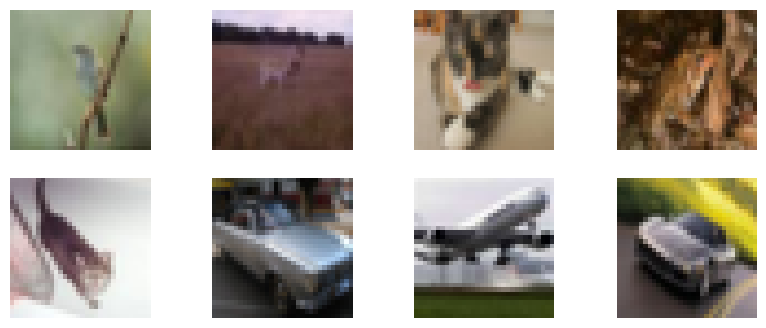

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.ToTensor()

dataset = datasets.CIFAR10(root="/kaggle/input/cifar10-python", train=True, download=False, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

images, labels = next(iter(loader))

plt.figure(figsize=(10,4))
for i in range(8):
    img = np.transpose(images[i].numpy(), (1,2,0))
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()


## **✅ Basic Image Operations (Resize, Crop, Rotate, Grayscale)**

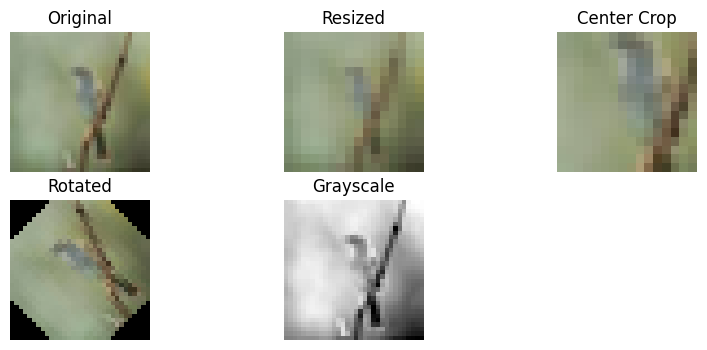

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

img = images[0]

ops = {
    "Original": img,
    "Resized": transforms.Resize((16,16))(img),
    "Center Crop": transforms.CenterCrop(16)(img),
    "Rotated": transforms.RandomRotation(45)(img),
    "Grayscale": transforms.Grayscale()(img)
}

plt.figure(figsize=(10,4))
for i, (name, im) in enumerate(ops.items()):
    plt.subplot(2, 3, i+1)
    arr = im.numpy().transpose(1,2,0)
    plt.imshow(arr.squeeze(), cmap="gray" if name=="Grayscale" else None)
    plt.title(name)
    plt.axis("off")
plt.show()


## **Traditional Computer Vision Features**

Before Deep Learning, CV used hand-crafted features:

✅ SIFT — Scale Invariant Feature Transform
✅ HOG — Histogram of Oriented Gradients
✅ SURF — Speeded Up Robust Features
❌ Limitations

Hard to design manually

Not robust for large-scale real-world data

Struggle with variations (lighting, pose, background)

Deep Learning replaced them with learned hierarchical features

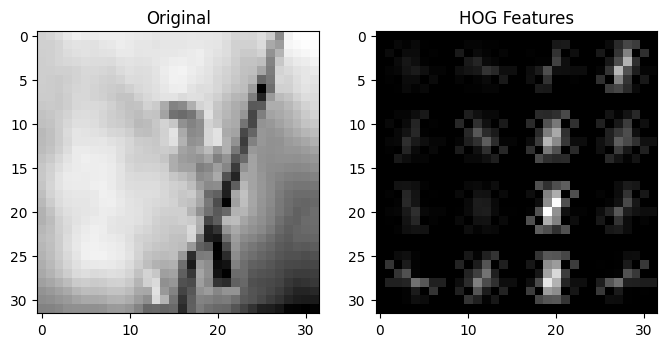

In [ ]:
from skimage.feature import hog
from skimage.color import rgb2gray

sample = images[0].numpy().transpose(1,2,0)
gray = rgb2gray(sample)

hog_features, hog_image = hog(gray, visualize=True)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Features")
plt.show()


# 📌 Deep Learning for Vision (CNNs)

## ✅ CNN Intuition
CNNs learn visual patterns at multiple levels:

- **Edges**
- **Shapes**
- **Textures**
- **Objects**

---

## ✅ Core CNN Layers

### 🔸 Convolution  
Extracts spatial features from the image.

### 🔸 ReLU  
Introduces non-linearity so the network can learn complex patterns.

### 🔸 Pooling  
Reduces spatial dimensions and keeps important features.

### 🔸 Dense Layer  
Acts as the classifier after feature extraction.

### 🔸 Softmax  
Converts outputs into probability scores.

---

CNNs enable **hierarchical feature learning** — from low-level edges to high-level objects.


In [ ]:
import torch.nn as nn
import torch

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 16x16

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 8x8

            nn.Flatten(),
            nn.Linear(64*8*8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleCNN()


## **✅ Code: Train the CNN on CIFAR-10**

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_cnn(epochs=3):
    for epoch in range(epochs):
        total, correct, total_loss = 0, 0, 0

        for imgs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(imgs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        print(f"Epoch {epoch+1}: Loss={total_loss:.3f}, Acc={correct/total:.3f}")

train_cnn()


Epoch 1: Loss=1091.391, Acc=0.499
Epoch 2: Loss=808.388, Acc=0.633
Epoch 3: Loss=690.481, Acc=0.690


## **✅ Code: Transfer Learning with ResNet18 (Feature Extraction)**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load CIFAR10 (should already be defined earlier)
# train_loader must exist before this block

# Load model WITHOUT pretrained weights (Kaggle offline)
resnet = models.resnet18(weights=None)

# Freeze all convolutional layers
for param in resnet.parameters():
    param.requires_grad = False

# Replace classifier for CIFAR-10 (10 classes)
resnet.fc = nn.Linear(512, 10)

# Loss function & optimizer (training only classifier)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=0.001)

print("Model ready for training!")


Model ready for training!


In [ ]:
# -------------------------
# 1) IMPORTS
# -------------------------
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -------------------------
# 2) LOAD CIFAR-10 (Kaggle offline)
# -------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(
    root="/kaggle/input/cifar10-python",
    train=True,
    download=False,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# -------------------------
# 3) BUILD RESNET18 (NO PRETRAINED WEIGHTS)
# -------------------------
resnet = models.resnet18(weights=None)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Replace classifier for CIFAR10
resnet.fc = nn.Linear(512, 10)

# -------------------------
# 4) LOSS & OPTIMIZER
# -------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=0.001)

# -------------------------
# 5) TRAINING LOOP
# -------------------------
def train_resnet(epochs=10):
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            optimizer.zero_grad()
            outputs = resnet(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)

        print(f"Epoch {epoch+1}: Loss={total_loss:.3f}, Acc={correct/total:.3f}")

# -------------------------
# 6) RUN TRAINING
# -------------------------
train_resnet()


Epoch 1: Loss=1593.203, Acc=0.268
Epoch 2: Loss=1519.785, Acc=0.306
